In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!which python

In [3]:
import arviz as az
from model import model_sim, param_gen
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json
import os

az.style.use("default")

In [4]:
subj_data_all = pd.read_csv("./Data/e1_data.csv")
group_id = 0
round_id = 0
subj_data = subj_data_all[(subj_data_all['group'] == group_id) & (subj_data_all['round'] == round_id)]
fitting_data = np.load(f"data/e1_fitting_data/SG_pars_poisson_{group_id}.npy", allow_pickle=True)
fitting_data_as = np.load(f"data/e1_fitting_data/AS_pars_poisson_{group_id}.npy", allow_pickle=True)

In [5]:
agent_id = 0
pars = ["agent_id", "group_id", "lambda","beta","tau"] # ,"eps_soc"

fitted_params = pd.DataFrame(data=np.exp(fitting_data_as[agent_id * 8 + round_id, 0, 2:]),
                             index=pars[2:], columns=["value"])

for l, p in zip(pars[2:], np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:])):
    print(f"{l}: {p}")

lambda: 0.7265764656663888
beta: 0.44939030271475666
tau: 0.01856678856848348


In [6]:
agent_id = 0
pars = ["agent_id", "group_id", "lambda","beta","tau","eps_soc"]

fitted_params = pd.DataFrame(data=np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:]), index=pars[2:], columns=["value"])

for l, p in zip(pars[2:], np.exp(fitting_data[agent_id * 8 + round_id, 0, 2:])):
    print(f"{l}: {p}")

lambda: 0.7265764656663888
beta: 0.44939030271475666
tau: 0.01856678856848348
eps_soc: 18.999999999999996


In [7]:
fitted_params.loc['lambda', 'value']

0.7265764656663888

In [8]:
env_id = subj_data.env.unique()[0]

In [52]:
path = 'data/environments'
json_files = [file for file in os.listdir(path) if file.endswith('_canon.json')]
envList_all = []
for file in json_files:
    f=open(os.path.join(path, file))
    envList_all.append(json.load(f))

torch.manual_seed(1)

np.random.seed(42)
n_groups_simulation = 6000
pars = param_gen(4, n_groups_simulation, hom=True, models=3)

pars[0][0]

{'lambda': 0.6055349943666803,
 'beta': 0.42017806748106945,
 'tau': 0.00728070961204776,
 'gamma': 0.0,
 'alpha': 0.0,
 'eps_soc': 0.7255074589209543,
 'dummy': 0.0}

### Training NLE

In [170]:
from sbi.analysis import pairplot
from sbi.inference.potentials.likelihood_based_potential import LikelihoodBasedPotential
from sbi.inference import MCMCPosterior, NLE
from sbi.utils import BoxUniform, MultipleIndependent, mcmc_transform
from torch.distributions import LogNormal, Exponential

In [175]:
params = ["lambda", "beta", "tau", "eps_soc"]  #
n_envs = 5.0
proposal = MultipleIndependent(
    [
        # BoxUniform(torch.tensor([0.0]), torch.tensor([1.0])),   # env
        # BoxUniform(torch.tensor([0.0]), torch.tensor([1.0])),   # trial
        # lambda, beta, tau, eps_soc
        # (-5,3),(-5,3),(-7.5,3),(-5,np.log(19))
        # BoxUniform(torch.tensor([-5]), torch.tensor([3])),   # lambda
        # BoxUniform(torch.tensor([-5]), torch.tensor([3])),   # beta
        # BoxUniform(torch.tensor([-7.5]), torch.tensor([3])),   # tau
        # # BoxUniform(torch.tensor([-5]), torch.tensor([np.log(19)])),   # eps_soc

        # uniform priors
        BoxUniform(torch.tensor([0.0001]), torch.tensor([2])),   # lambda
        BoxUniform(torch.tensor([0.0001]), torch.tensor([2])),   # beta
        BoxUniform(torch.tensor([0.0001]), torch.tensor([0.1])),   # tau
        BoxUniform(torch.tensor([0.0001]), torch.tensor([20])),   # eps_soc
        BoxUniform(torch.tensor([0.0]), torch.tensor([n_envs - 1.0])),   # env
        # BoxUniform(torch.tensor([0.0]), torch.tensor([14.0])),   # trial

        # weakly informed priors
        # LogNormal(torch.tensor([-0.75]), torch.tensor([1])),  # lambda # 0.5
        # LogNormal(torch.tensor([-0.75]), torch.tensor([1])),  # beta  # 0.5
        # LogNormal(torch.tensor([-4.5]), torch.tensor([1.5])),   # tau # 0.9
        # Exponential(torch.tensor([0.1])),                       # eps_soc
    ],
    validate_args=False,
)

num_simulations = n_groups_simulation * 4
proposal_samples = proposal.sample((num_simulations,))
# plt.hist(prior_samples[:, 0], bins=100)

In [172]:
trainer = NLE(proposal, show_progress_bars=True, density_estimator="mdn")

In [173]:
for i in range(n_groups_simulation):
    for a in range(4):
        # set all parameters in pars to 0
        for k in pars[i][a].keys():
            pars[i][a][k] = 0.0

        for ii, p in enumerate(params):
            pars[i][a][p] = proposal_samples[i * 4 + a, ii].item()

pars[0][0]

{'lambda': 1.9428672790527344,
 'beta': 0.17273229360580444,
 'tau': 0.05388624966144562,
 'gamma': 0.0,
 'alpha': 0.0,
 'eps_soc': 11.02414608001709,
 'dummy': 0.0}

In [176]:
# select only one environment
envList =  [[envList_all[i][ii] for ii in range(int(n_envs))] for i in range(len(envList_all))]

In [181]:
simulations = model_sim(pars, envList, 1, 15, payoff=True)  # pars[:2]

cols = ['lambda', 'beta', 'tau', 'eps_soc', 'env']  #
theta = torch.tensor(simulations[cols].to_numpy(), dtype=torch.float32)
x = torch.tensor(simulations['choice'].to_numpy(), dtype=torch.float32).unsqueeze(1)

In [184]:
theta

tensor([[ 1.9429,  0.1727,  0.0539, 11.0241,  1.0000],
        [ 1.9429,  0.1727,  0.0539, 11.0241,  1.0000],
        [ 1.9429,  0.1727,  0.0539, 11.0241,  1.0000],
        ...,
        [ 0.1061,  0.6127,  0.0320,  0.0675,  4.0000],
        [ 0.1061,  0.6127,  0.0320,  0.0675,  4.0000],
        [ 0.1061,  0.6127,  0.0320,  0.0675,  4.0000]])

In [185]:
%%time
estimator = trainer.append_simulations(theta, x)
density_estimator = estimator.train()

/Users/valery/Library/Caches/pypoetry/virtualenvs/socialgeneralizationsbi-kycarzEV-py3.9/lib/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


 Neural network successfully converged after 141 epochs.CPU times: user 43min 26s, sys: 3min 38s, total: 47min 5s
Wall time: 13min 14s


### Fit simulated data

In [186]:
sim_param_o = pars[:6]
params = ["lambda", "beta", "tau", "eps_soc"]
ground_truth = pd.DataFrame(columns=params, index=[0], dtype=float)
ground_truth.loc[0, :] = [1.11, 0.33, 0.03, 12.55]

# simulated data
for i in range(2):
    for a in range(4):
        # set all parameters in pars to 0
        for k in sim_param_o[i][a].keys():
            sim_param_o[i][a][k] = 0.0

        for ii, p in enumerate(params):
            sim_param_o[i][a][p] = ground_truth.loc[0, p]

sim_param_o[0][0]

{'lambda': 1.11,
 'beta': 0.33,
 'tau': 0.03,
 'gamma': 0.0,
 'alpha': 0.0,
 'eps_soc': 12.55,
 'dummy': 0.0}

In [187]:
simulations_o = model_sim(sim_param_o, envList, 1, 15, payoff=True)
theta_o = torch.tensor(simulations_o[params + ['env']].to_numpy(), dtype=torch.float32)
x_o = torch.tensor(simulations_o['choice'].to_numpy(), dtype=torch.float32).unsqueeze(1).T

In [196]:
num_samples = 50_000

mcmc_parameters = dict(
    num_chains=40,
    thin=1,
    warmup_steps=500,
    init_strategy="proposal",
    num_workers=8
)
mcmc_method = "slice_np_vectorized"  # "nuts_pyro"

# posterior = trainer.build_posterior(
#     mcmc_method=mcmc_method,
#     mcmc_parameters=mcmc_parameters,
# )

prior = MultipleIndependent(
    [
        # uniform priors
        # BoxUniform(torch.tensor([0.0001]), torch.tensor([2])),   # lambda
        # BoxUniform(torch.tensor([0.0001]), torch.tensor([2])),   # beta
        # BoxUniform(torch.tensor([0.0001]), torch.tensor([0.1])),   # tau
        # BoxUniform(torch.tensor([0.0001]), torch.tensor([20])),   # eps_soc

        # weakly informed priors
        LogNormal(torch.tensor([-0.3]), torch.tensor([0.6])),  # lambda
        LogNormal(torch.tensor([-0.3]), torch.tensor([0.6])),  # beta
        LogNormal(torch.tensor([-4.0]), torch.tensor([0.6])),   # tau
        Exponential(torch.tensor([0.2])),                       # eps_soc
    ],
    validate_args=False,
)

prior_transform = mcmc_transform(prior)

potential_fn = LikelihoodBasedPotential(density_estimator, prior)

conditioned_potential_fn = potential_fn.condition_on_theta(
    theta_o[:, 4:],  # pass only the conditions, must match the batch of iid data in x_o
    dims_global_theta=[0, 1, 2, 3]
)

posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=prior_transform,
    proposal=prior,  # pass the prior, not the proposal.
    method=mcmc_method,
    **mcmc_parameters
)


In [197]:
posterior_sample = posterior.sample((num_samples,), x=x_o.T)

/Users/valery/Library/Caches/pypoetry/virtualenvs/socialgeneralizationsbi-kycarzEV-py3.9/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:741: UserWarning: Parallelization of vectorized slice sampling not implement, running serially.
  posterior_sampler = SliceSamplerMultiChain(


Running vectorized MCMC with 40 chains:   0%|          | 0/72000 [00:00<?, ?it/s]

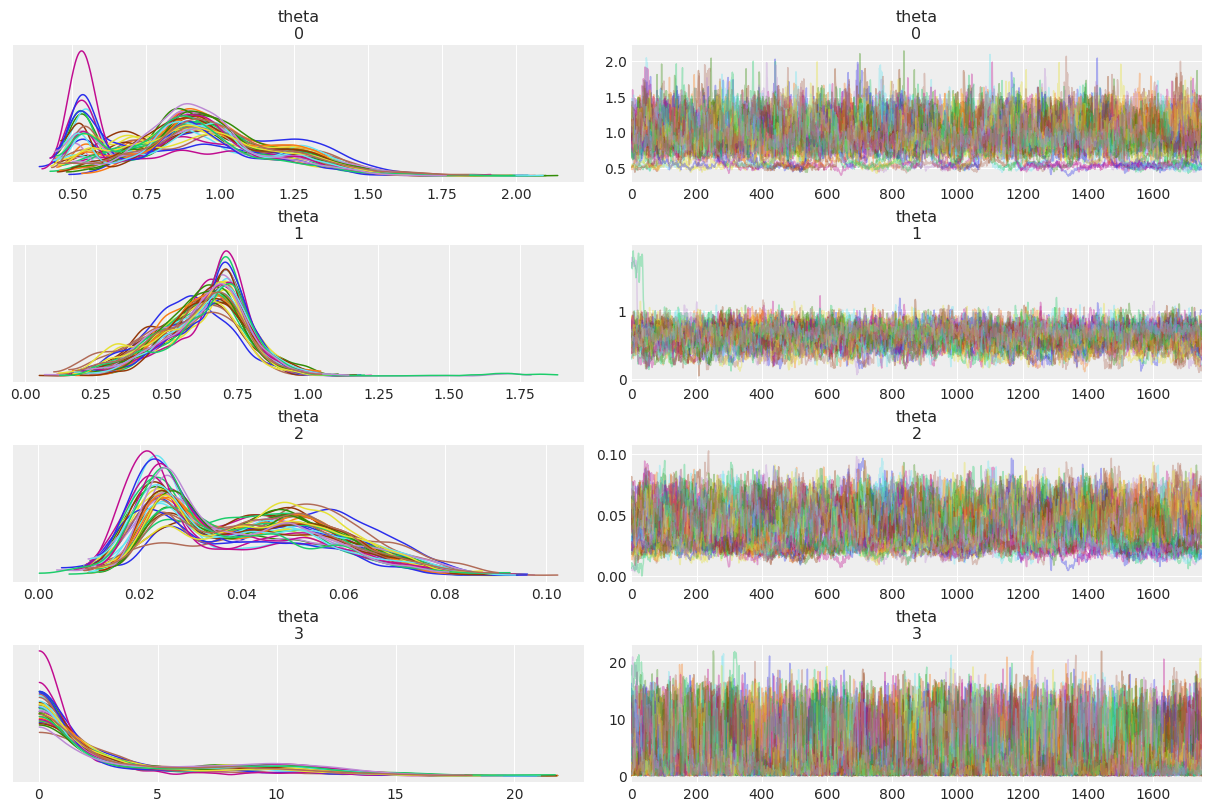

In [198]:
inference_data = posterior.get_arviz_inference_data()
with az.style.context("arviz-darkgrid"):
    az.plot_trace(inference_data, compact=False)
plt.show()

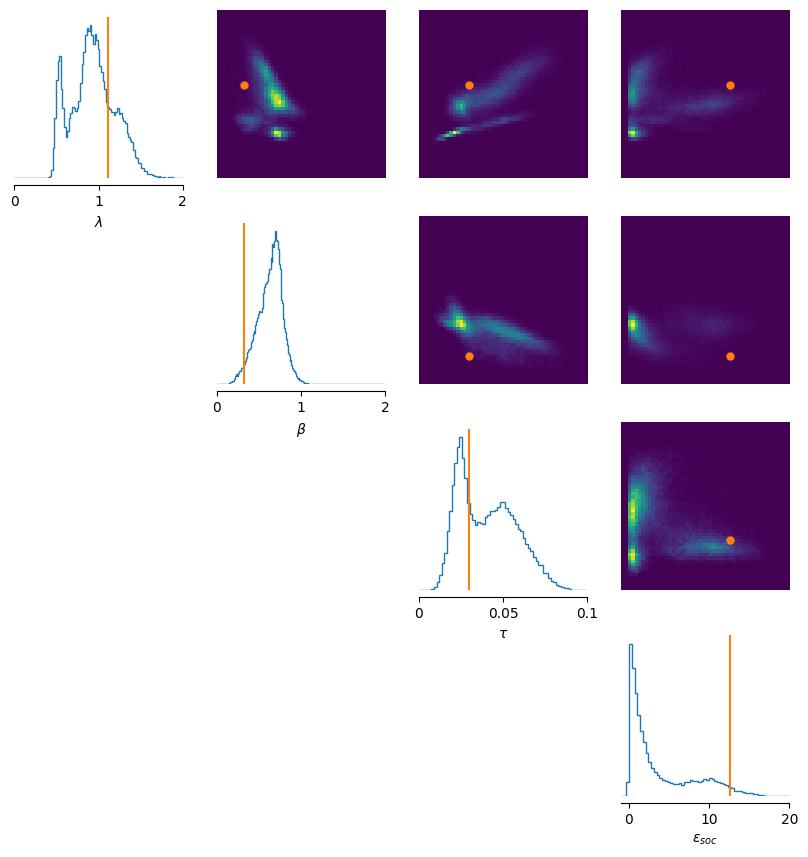

In [199]:
params = ["lambda", "beta", "tau", "eps_soc"]  #
labels = ["$\lambda$", "$\\beta$", "$\\tau$", "$\\epsilon_{soc}$"]  #
limits = [[0, 2], [0, 2], [0, 0.1], [-1, 20]]

_ = pairplot(posterior_sample,
             limits=limits,
             points=np.array([ground_truth.loc[0, params]]),
             figsize=(10, 10),
             labels=labels,
             )
plt.show()

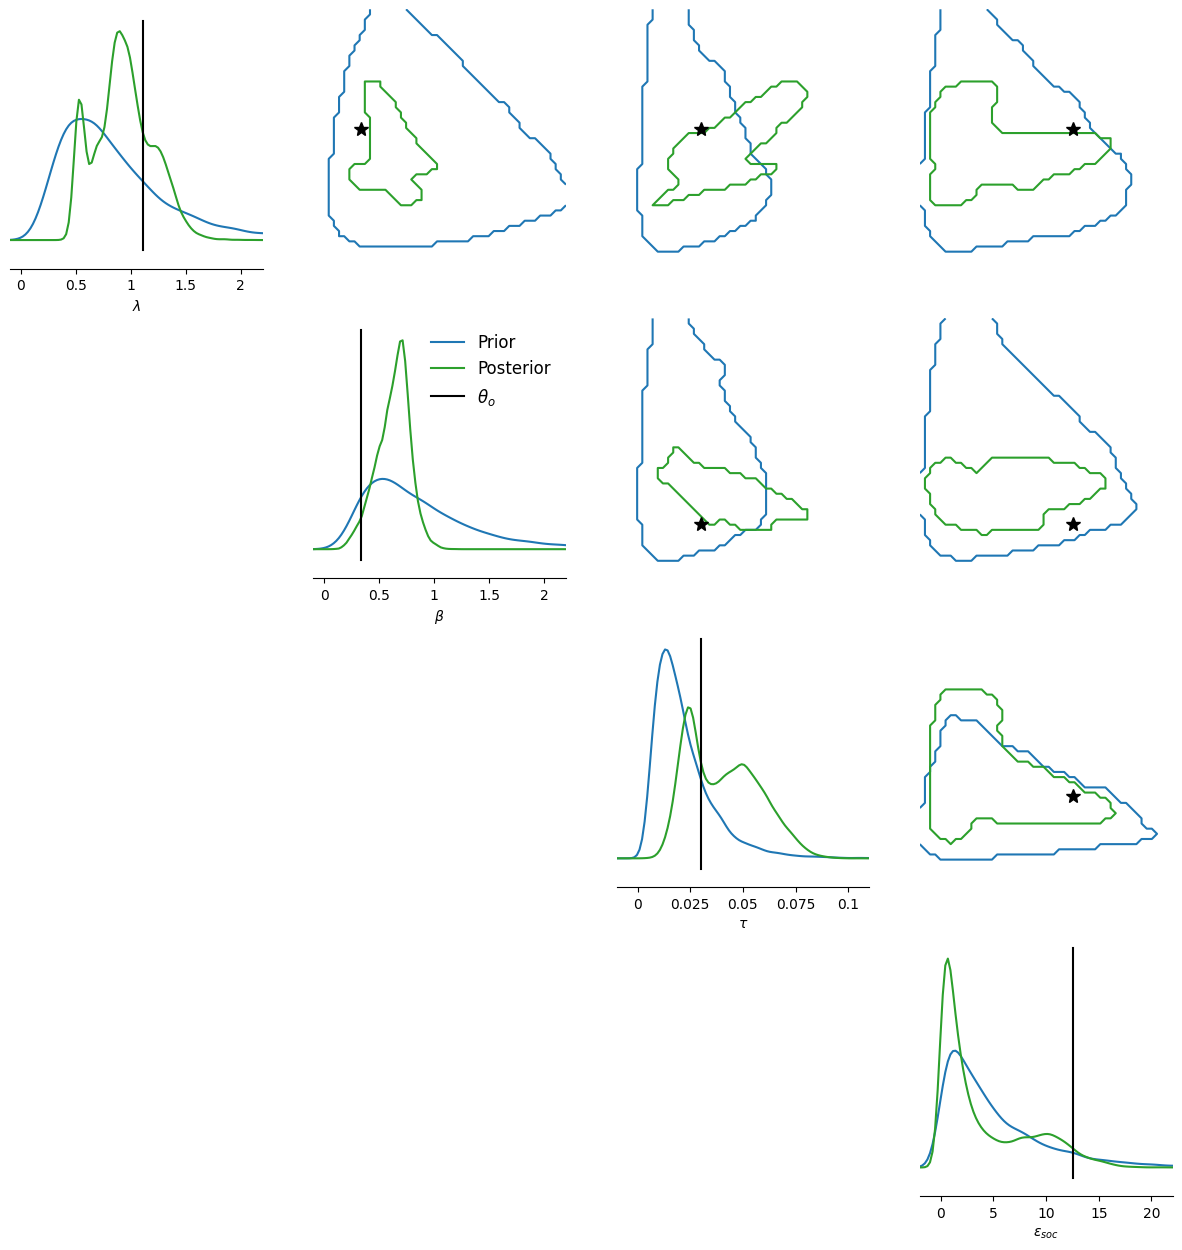

In [200]:
params = ["lambda", "beta", "tau", "eps_soc"]  #
labels = ["$\lambda$", "$\\beta$", "$\\tau$", "$\\epsilon_{soc}$"]  #
limits = [[-0.1, 2.2], [-0.1, 2.2], [-0.01, 0.11], [-2, 22]]


fig, ax = pairplot(
    [
        prior.sample((10_000,)), # .exp(),
        posterior_sample, # .exp(),
    ],
    points=np.array([ground_truth.loc[0, params]]),
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    limits=limits,
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=labels,
    figsize=(15, 15),
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Posterior", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
)
plt.show()

### Fit human data

In [29]:
# real data
agent_id = 3
_x_o = subj_data.loc[subj_data['agent'] == agent_id, 'choice'].values
x_o = torch.tensor([_x_o], dtype=torch.float32)
posterior_sample = posterior.sample((num_samples,), x=x_o.T)

/var/folders/j1/yztn44qj3cx5txyykg20nctr0000gn/T/ipykernel_56830/153715242.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  x_o = torch.tensor([_x_o], dtype=torch.float32)


In [501]:
_pars = ["agent_id", "group_id", "lambda","beta","tau","eps_soc"]
print(fitting_data[(agent_id - 1) * 8 + round_id, 0, 0:2])
fitted_params = pd.DataFrame(data=np.exp(fitting_data[(agent_id - 1) * 8 + round_id, 0, 2:]),
                             index=_pars[2:], columns=["value"])

[3. 0.]


In [443]:
inference_data = posterior.get_arviz_inference_data()

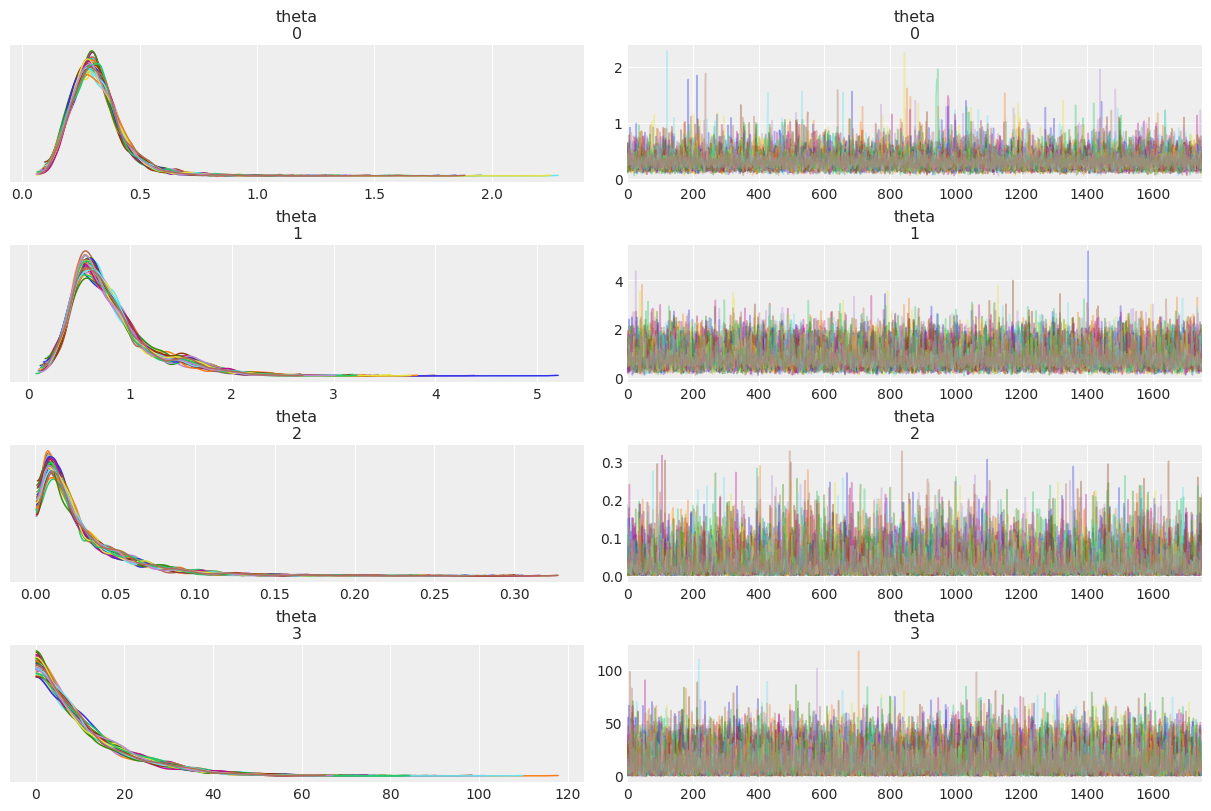

In [416]:
with az.style.context("arviz-darkgrid"):
    az.plot_trace(inference_data, compact=False)

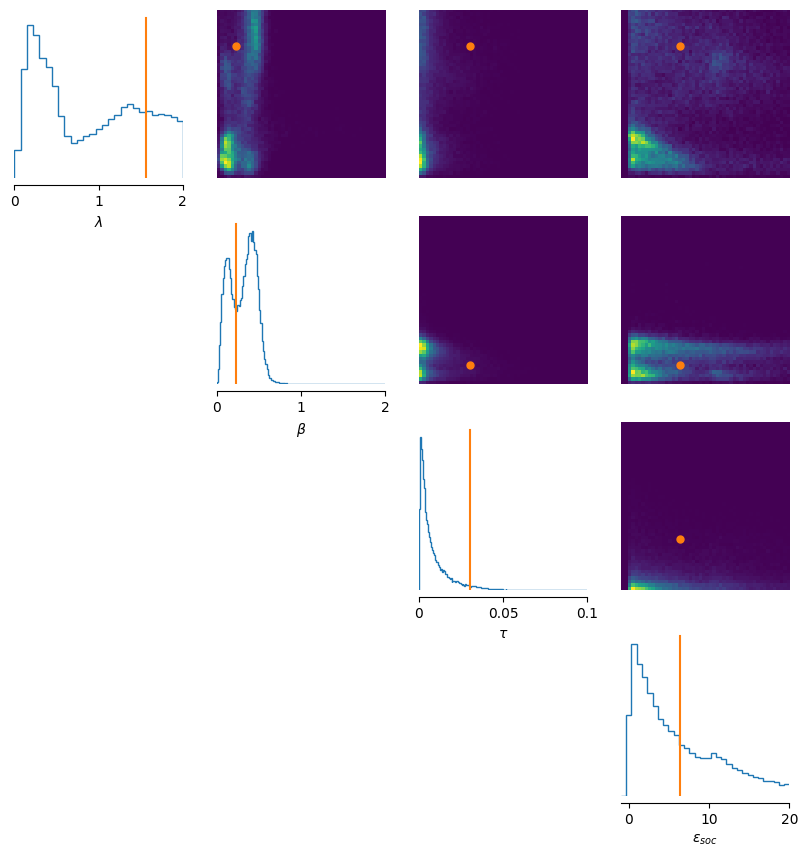

In [502]:
params = ["lambda", "beta", "tau", "eps_soc"]  #
labels = ["$\lambda$", "$\\beta$", "$\\tau$", "$\\epsilon_{soc}$"]  #
limits = [[0, 2], [0, 2], [0, 0.1], [-1, 20]]

_ = pairplot(posterior_sample, # .exp(),
             limits=limits,
             points=np.array([fitted_params.loc[params, 'value']]),
             figsize=(10, 10),
             labels=labels,
             )

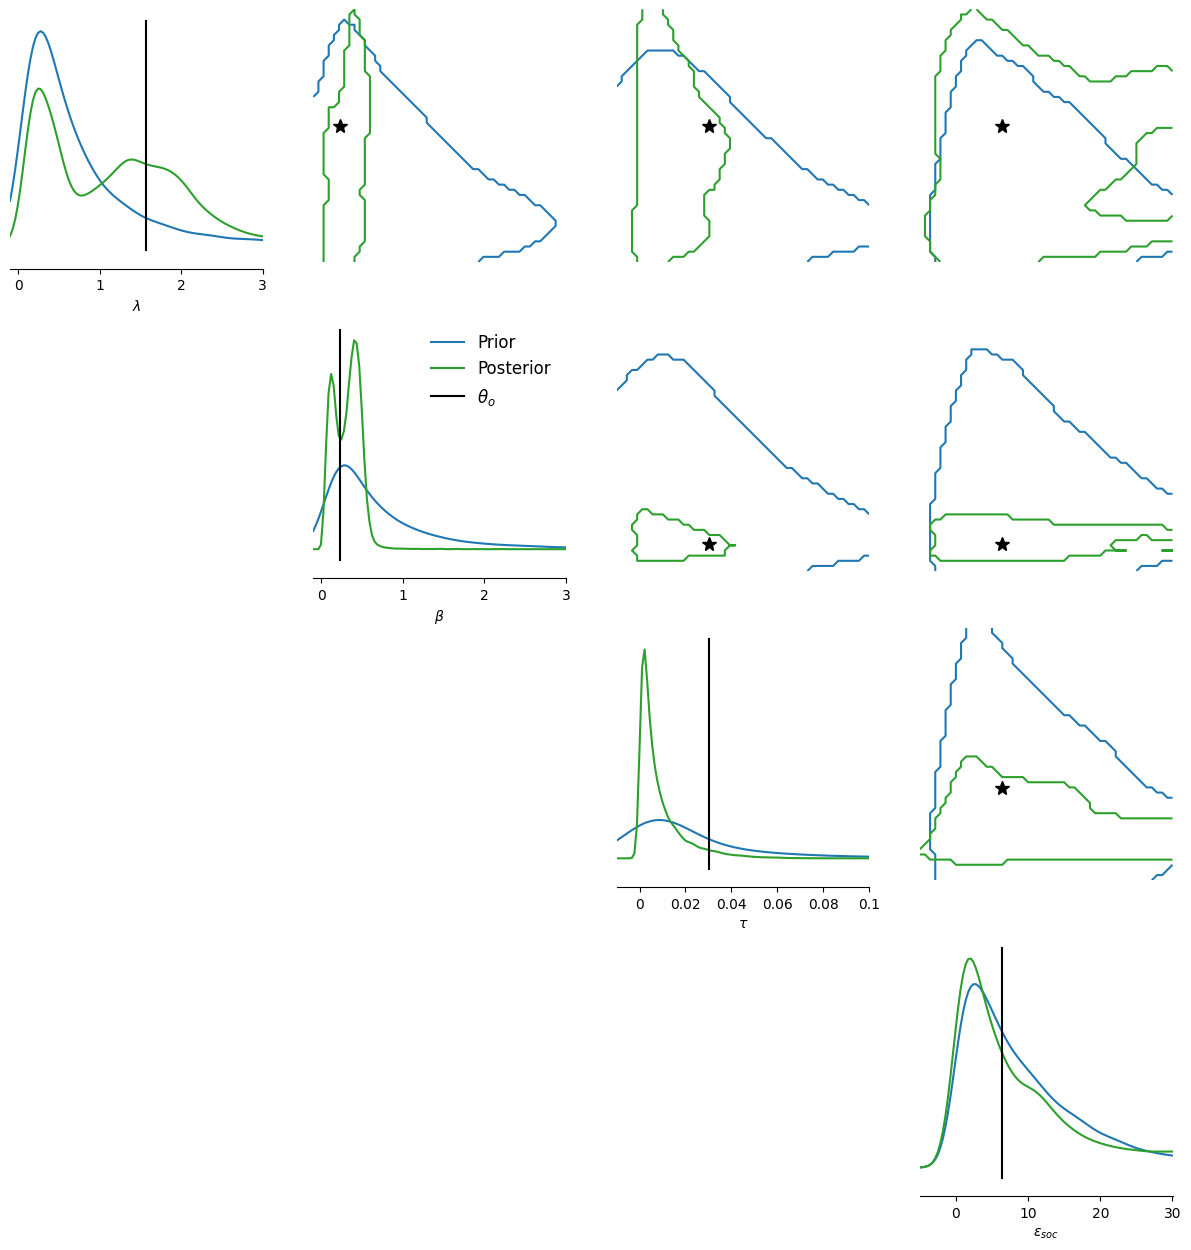

In [503]:
params = ["lambda", "beta", "tau", "eps_soc"]  #
labels = ["$\lambda$", "$\\beta$", "$\\tau$", "$\\epsilon_{soc}$"]  #
limits = [[-0.1, 3], [-0.1, 3], [-0.01, 0.1], [-5, 30]]


fig, ax = pairplot(
    [
        prior.sample((10_000,)), # .exp(),
        posterior_sample, # .exp(),
    ],
    points=np.array([fitted_params.loc[params, 'value']]),
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    limits=limits,
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=labels,
    figsize=(15, 15),
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Posterior", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
)

In [504]:
np.float32(posterior_sample.mean(axis=0))

array([1.1609406e+00, 3.1159103e-01, 8.6829783e-03, 1.1182898e+01],
      dtype=float32)

In [505]:
fitted_params

,value
lambda,1.564209
beta,0.232399
tau,0.030251
eps_soc,6.357610
